<a href="https://colab.research.google.com/github/felicia2025-hue/Customer-Segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Understanding

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Load dataset
file_path = "/content/superstore_dataset.xlsx"
xls = pd.ExcelFile(file_path)
df = xls.parse('segmentation - superstore')

In [ ]:
print("Shape df:", df.shape)
print("\nKolom:\n", df.columns.tolist())

# Tipe data
print("\nDtypes:\n", df.dtypes)
print("\nHead:")
display(df.head(3))

Shape df: (9994, 21)

Kolom:
 ['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode', 'customer_id', 'customer_name', 'segment', 'country', 'city', 'state', 'postal_code', 'region', 'product_id', 'category', 'subcategory', 'product_name', 'sales', 'quantity', 'discount', 'profit']

Dtypes:
 row_id                    int64
order_id                 object
order_date       datetime64[ns]
ship_date        datetime64[ns]
ship_mode                object
customer_id              object
customer_name            object
segment                  object
country                  object
city                     object
state                    object
postal_code               int64
region                   object
product_id               object
category                 object
subcategory              object
product_name             object
sales                   float64
quantity                  int64
discount                float64
profit                  float64
dtype: object

Head:


,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,subcategory,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


# Data Preparation

In [ ]:
# Cek missing values dan duplikasi
cleaning_report = {
    "missing_values": df.isnull().sum().sum(),
    "duplicate_rows": df.duplicated().sum()
}
cleaning_report

{'missing_values': np.int64(0), 'duplicate_rows': np.int64(0)}

In [ ]:
# Membuat tanggal referensi
reference_date = df['order_date'].max() + timedelta(days=1)

# Feature Selection (RFM)

In [ ]:
# Membuat data RFM
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (reference_date - x.max()).days,
    'order_id': 'nunique',
    'sales': 'sum'
}).reset_index()
rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
rfm

,customer_id,recency,frequency,monetary
0,AA-10315,185,5,5563.560
1,AA-10375,20,9,1056.390
2,AA-10480,260,4,1790.512
3,AA-10645,56,6,5086.935
4,AB-10015,416,3,886.156
...,...,...,...,...
788,XP-21865,44,11,2374.658
789,YC-21895,5,5,5454.350
790,YS-21880,10,8,6720.444
791,ZC-21910,55,13,8025.707


# Exploratory Data Analysis (Before Clustering)


In [ ]:
# EDA: Statistik deskriptif
eda_summary = rfm.describe()
eda_summary

,recency,frequency,monetary
count,793.000000,793.000000,793.000000
mean,147.802018,6.316520,2896.848500
std,186.211051,2.550885,2628.670117
min,1.000000,1.000000,4.833000
25%,31.000000,5.000000,1146.050000
50%,76.000000,6.000000,2256.394000
75%,184.000000,8.000000,3785.276000
max,1166.000000,17.000000,25043.050000


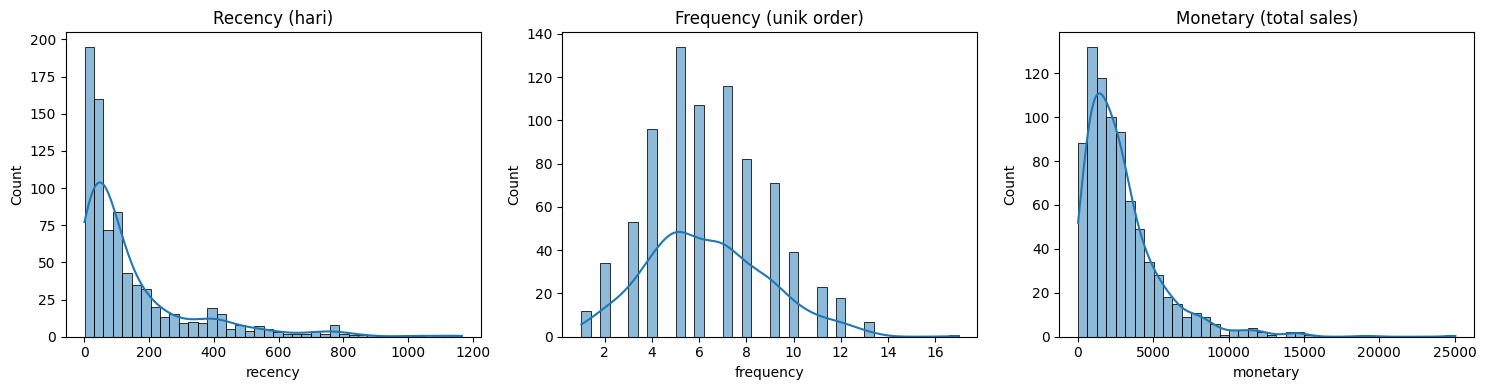

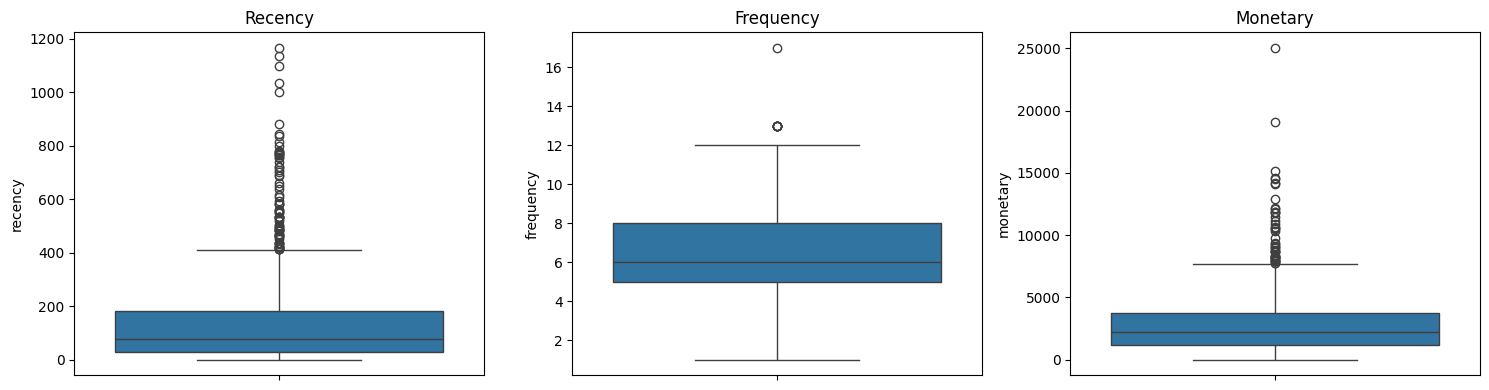

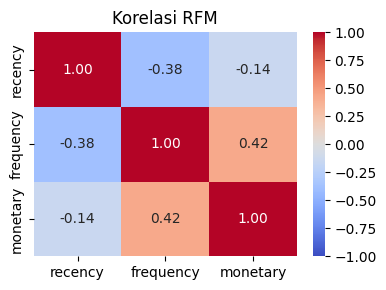

In [ ]:
# Histogram RFM
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.histplot(rfm['recency'], bins=40, ax=axes[0], kde=True); axes[0].set_title('Recency (hari)')
sns.histplot(rfm['frequency'], bins=40, ax=axes[1], kde=True); axes[1].set_title('Frequency (unik order)')
sns.histplot(rfm['monetary'], bins=40, ax=axes[2], kde=True); axes[2].set_title('Monetary (total sales)')
plt.tight_layout(); plt.show()

# Boxplot RFM (cek outlier)
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.boxplot(y=rfm['recency'], ax=axes[0]); axes[0].set_title('Recency')
sns.boxplot(y=rfm['frequency'], ax=axes[1]); axes[1].set_title('Frequency')
sns.boxplot(y=rfm['monetary'], ax=axes[2]); axes[2].set_title('Monetary')
plt.tight_layout(); plt.show()

# Korelasi RFM
corr = rfm[['recency','frequency','monetary']].corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Korelasi RFM')
plt.tight_layout(); plt.show()

# Data Transformation

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency','frequency','monetary']])

# Algorithm Selection (KMeans)

###### The chosen algorithm is K-Means because it performs well on numerical data (like Recency, Frequency, and Monetary) and provides clear cluster boundaries

# Parameter Determination

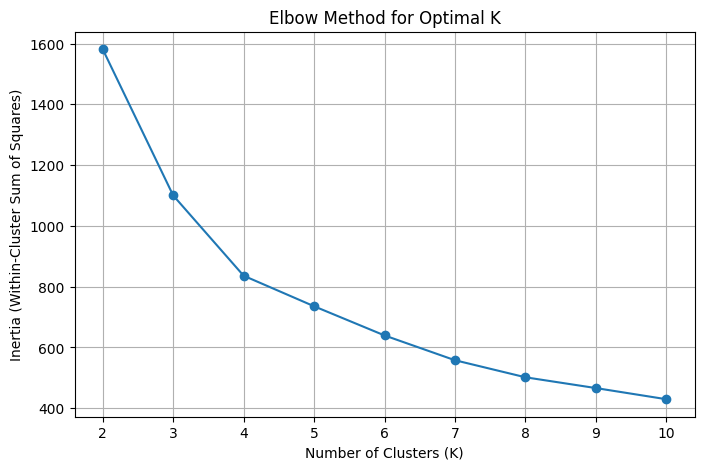

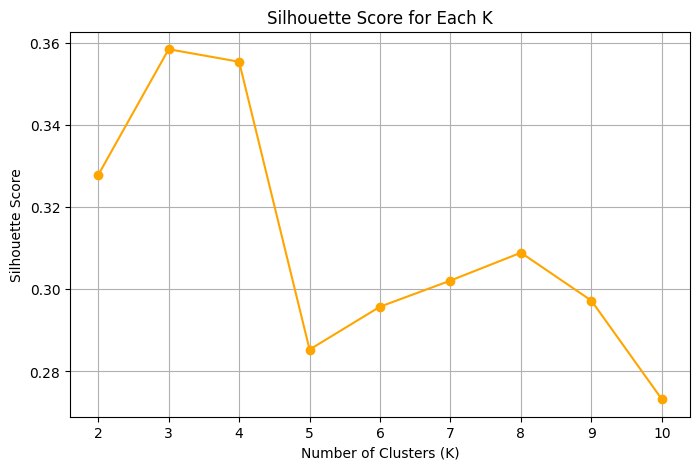

Elbow Method suggests K ≈ 2
Highest Silhouette Score at K = 3
Final chosen K = 3


In [ ]:
from sklearn.metrics import silhouette_score

K_values = range(2, 11)
inertia = []
silhouette_scores = []

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(sil)

# ----- Plot Elbow Method -----
plt.figure(figsize=(8, 5))
plt.plot(K_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(K_values)
plt.grid(True)
plt.show()

# ----- Plot Silhouette Scores -----
plt.figure(figsize=(8, 5))
plt.plot(K_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score for Each K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K_values)
plt.grid(True)
plt.show()

# ----- Automatically detect best K -----
best_k_elbow = np.diff(inertia).argmin() + 2
best_k_silhouette = np.argmax(silhouette_scores) + 2
optimal_k = best_k_silhouette

print(f"Elbow Method suggests K ≈ {best_k_elbow}")
print(f"Highest Silhouette Score at K = {best_k_silhouette}")
print(f"Final chosen K = {optimal_k}")

###### In this project, the Euclidean distance was used as the distance metric. This is because the K-Means algorithm inherently relies on Euclidean distance to measure the similarity between data points and their corresponding cluster centroids.

In [ ]:
# Euclidean distance
final_kmeans = KMeans(n_clusters=int(optimal_k), random_state=42, n_init=50)
rfm['cluster'] = final_kmeans.fit_predict(rfm_scaled).astype(int)

# Evaluation

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

sil_global = silhouette_score(rfm_scaled, rfm['cluster'])
db_index = davies_bouldin_score(rfm_scaled, rfm['cluster'])
ch_index = calinski_harabasz_score(rfm_scaled, rfm['cluster'])

silhouette_val = round(sil_global, 3)
dbi_val = round(db_index, 3)
ch_val = round(ch_index, 3)

# Silhouette: higher better
if silhouette_val < 0.25:
    sil_quality = "Poor (cluster overlap too high)"
elif silhouette_val < 0.5:
    sil_quality = "Fair / Acceptable (moderate separation)"
else:
    sil_quality = "Good (clear, compact clusters)"

# Davies-Bouldin: lower better
if dbi_val > 2.0:
    dbi_quality = "Poor (clusters too similar)"
elif dbi_val > 1.0:
    dbi_quality = "Fair (moderate similarity)"
else:
    dbi_quality = "Good (clusters well separated)"

# Calinski-Harabasz: higher better
if ch_val < 200:
    ch_quality = "Weak (low between-cluster variance)"
elif ch_val < 500:
    ch_quality = "Moderate (reasonable separation)"
else:
    ch_quality = "Strong (highly distinct clusters)"

# --- Tabel ringkasan ---
metrics_summary = pd.DataFrame({
    "Metric": ["Silhouette Score", "Davies–Bouldin Index", "Calinski–Harabasz Index"],
    "Value": [silhouette_val, dbi_val, ch_val],
    "Better Direction": ["Higher", "Lower", "Higher"],
    "Interpretation": [sil_quality, dbi_quality, ch_quality]
})

print("\n=== Key Clustering Metrics (with Interpretation) ===")
display(metrics_summary)

# --- Kesimpulan umum ---
if silhouette_val >= 0.25 and dbi_val <= 1.5:
    print("Overall clustering performance is GOOD for customer segmentation use.")
    print("   The clusters show reasonable separation and compactness for business interpretation.")
else:
    print("⚠️ Clustering quality is moderate — consider feature scaling or adjusting K for improvement.")



=== Key Clustering Metrics (with Interpretation) ===


,Metric,Value,Better Direction,Interpretation
0,Silhouette Score,0.358,Higher,Fair / Acceptable (moderate separation)
1,Davies–Bouldin Index,0.985,Lower,Good (clusters well separated)
2,Calinski–Harabasz Index,459.052,Higher,Moderate (reasonable separation)


Overall clustering performance is GOOD for customer segmentation use.
   The clusters show reasonable separation and compactness for business interpretation.


# Clustering Visualization

/tmp/ipython-input-3481905359.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x='cluster', y='recency', order=cluster_order,
/tmp/ipython-input-3481905359.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x='cluster', y='frequency', order=cluster_order,
/tmp/ipython-input-3481905359.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x='cluster', y='monetary', order=cluster_order,


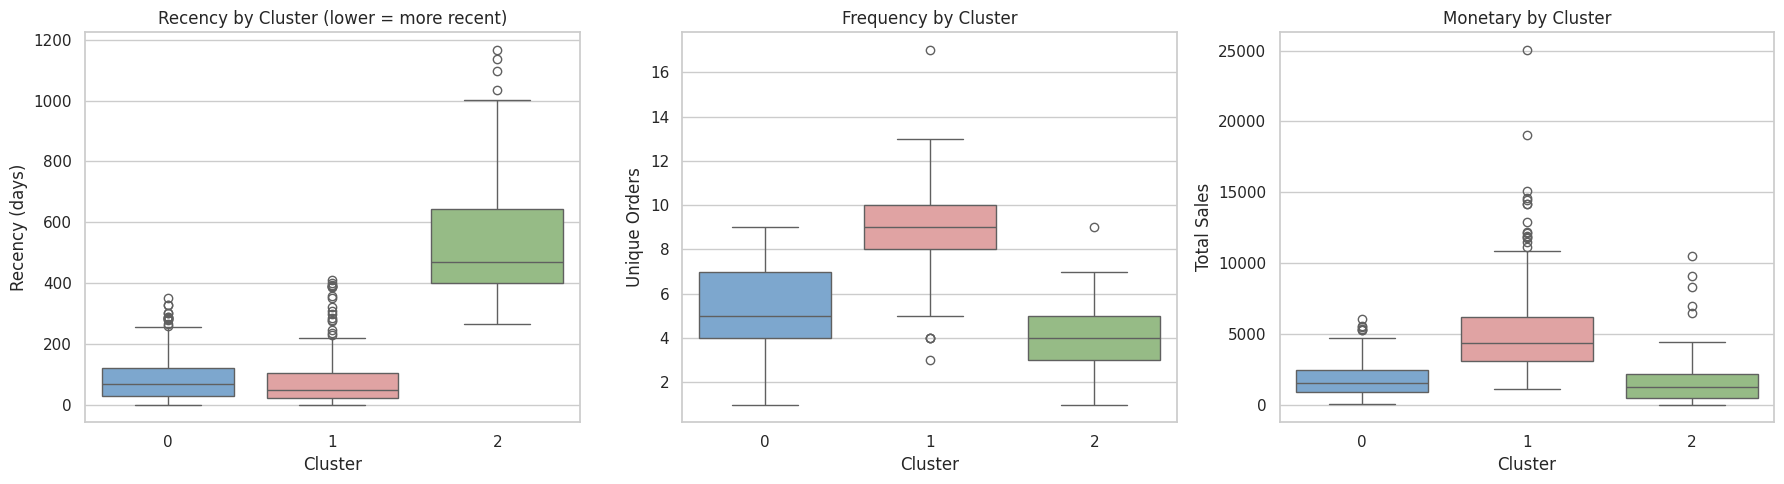

=== Average RFM Values per Cluster ===


,Avg Recency (days),Avg Frequency,Avg Monetary (Sales)
Cluster,,,
0,88.7,5.3,1772.2
1,80.3,8.8,5131.0
2,531.4,3.8,1636.9


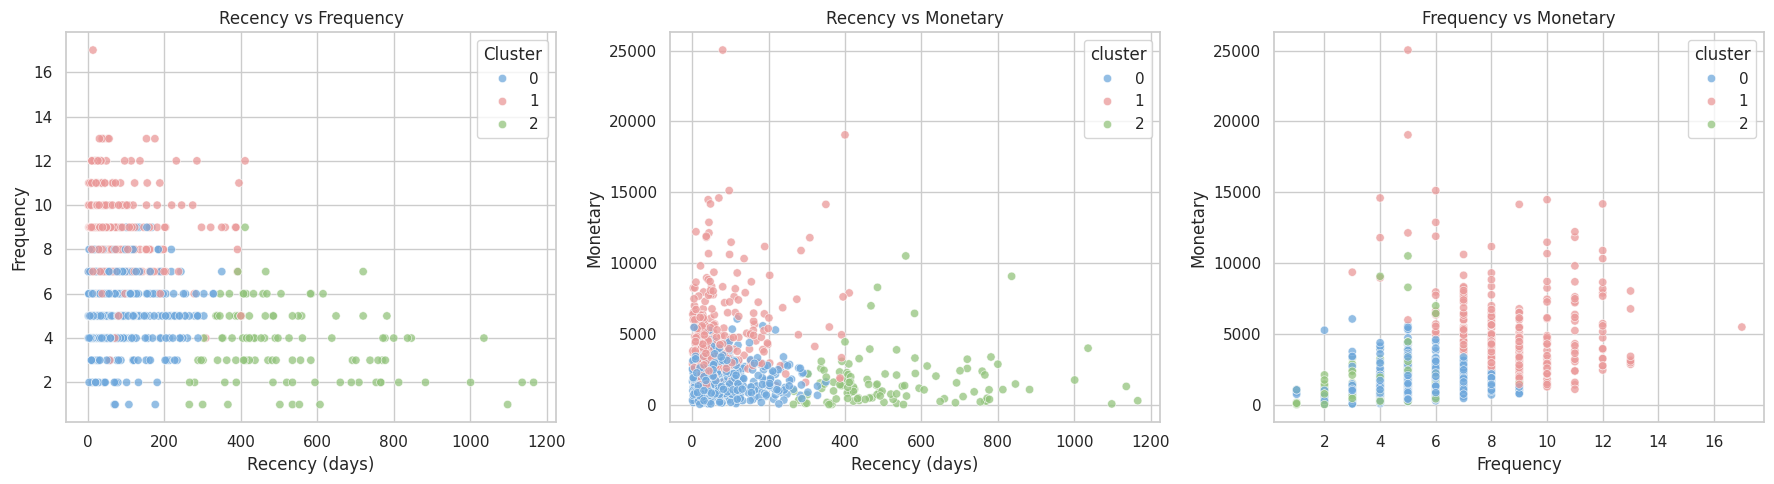

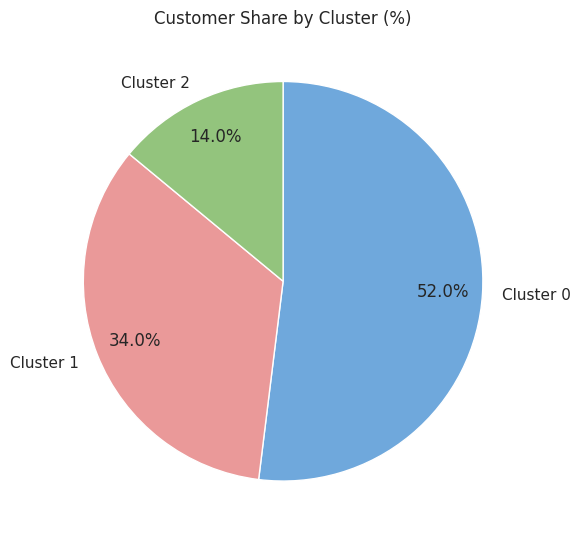

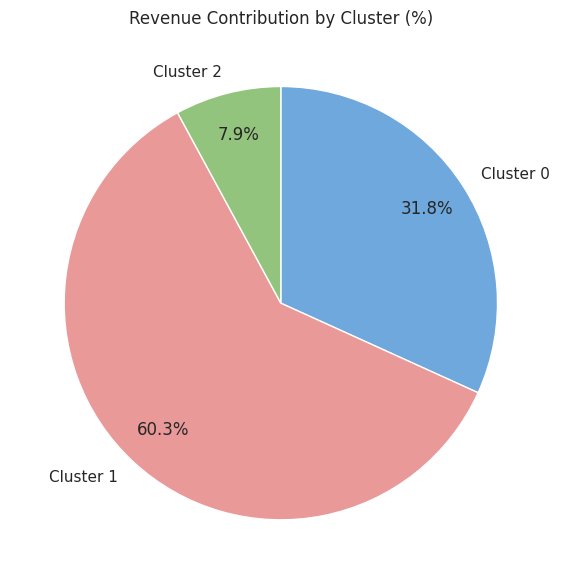

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

sns.set(style="whitegrid")

# Ensure cluster dtype & order
rfm['cluster'] = rfm['cluster'].astype(int)
cluster_order = sorted(rfm['cluster'].unique())

# --- Softer pastel color palette ---
soft_colors = ['#6FA8DC', '#EA9999', '#93C47D']  # soft blue, soft red, mint green
color_cycle = cycle(soft_colors)
palette_map = {c: next(color_cycle) for c in cluster_order}
ordered_colors = [palette_map[c] for c in cluster_order]

# ---------- BOXPLOTS: R, F, M ----------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=rfm, x='cluster', y='recency', order=cluster_order,
            palette=ordered_colors, ax=axes[0])
axes[0].set_title('Recency by Cluster (lower = more recent)')
axes[0].set_xlabel('Cluster'); axes[0].set_ylabel('Recency (days)')

sns.boxplot(data=rfm, x='cluster', y='frequency', order=cluster_order,
            palette=ordered_colors, ax=axes[1])
axes[1].set_title('Frequency by Cluster')
axes[1].set_xlabel('Cluster'); axes[1].set_ylabel('Unique Orders')

sns.boxplot(data=rfm, x='cluster', y='monetary', order=cluster_order,
            palette=ordered_colors, ax=axes[2])
axes[2].set_title('Monetary by Cluster')
axes[2].set_xlabel('Cluster'); axes[2].set_ylabel('Total Sales')

plt.tight_layout()
plt.show()

# ---------- TABLE OF MEAN RFM PER CLUSTER ----------
import pandas as pd

# Hitung rata-rata tiap metrik per cluster
rfm_means = (
    rfm.groupby('cluster')[['recency', 'frequency', 'monetary']]
       .mean()
       .round(1)
       .reindex(cluster_order)
)

# Tampilkan tabel dengan format rapi
rfm_table = pd.DataFrame(rfm_means)
rfm_table.index.name = 'Cluster'
rfm_table.columns = ['Avg Recency (days)', 'Avg Frequency', 'Avg Monetary (Sales)']

print("=== Average RFM Values per Cluster ===")
display(rfm_table)

# ---------- SCATTER PATTERNS (RFM) ----------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=rfm, x='recency', y='frequency', hue='cluster',
                hue_order=cluster_order, palette=palette_map, alpha=0.75, ax=axes[0])
axes[0].set_title('Recency vs Frequency')
axes[0].set_xlabel('Recency (days)'); axes[0].set_ylabel('Frequency')
axes[0].legend(title='Cluster')

sns.scatterplot(data=rfm, x='recency', y='monetary', hue='cluster',
                hue_order=cluster_order, palette=palette_map, alpha=0.75, ax=axes[1])
axes[1].set_title('Recency vs Monetary')
axes[1].set_xlabel('Recency (days)'); axes[1].set_ylabel('Monetary')

sns.scatterplot(data=rfm, x='frequency', y='monetary', hue='cluster',
                hue_order=cluster_order, palette=palette_map, alpha=0.75, ax=axes[2])
axes[2].set_title('Frequency vs Monetary')
axes[2].set_xlabel('Frequency'); axes[2].set_ylabel('Monetary')

plt.tight_layout()
plt.show()

# ---------- PIE CHARTS ----------
# Customer share (how many customers in each cluster)
cust_counts = rfm['cluster'].value_counts().sort_index()
labels = [f'Cluster {c}' for c in cluster_order]
sizes_customers = [cust_counts.get(c, 0) for c in cluster_order]

plt.figure(figsize=(6, 6))
plt.pie(sizes_customers, labels=labels, colors=ordered_colors,
        autopct='%1.1f%%', startangle=90, counterclock=False, pctdistance=0.8)
plt.title('Customer Share by Cluster (%)')
plt.tight_layout()
plt.show()

# Revenue share (total monetary contribution)
rev_per_cluster = rfm.groupby('cluster')['monetary'].sum().reindex(cluster_order, fill_value=0)
sizes_revenue = rev_per_cluster.values
rev_labels = [f'Cluster {c}' for c in cluster_order]

plt.figure(figsize=(6, 6))
plt.pie(sizes_revenue, labels=rev_labels, colors=ordered_colors,
        autopct='%1.1f%%', startangle=90, counterclock=False, pctdistance=0.8)
plt.title('Revenue Contribution by Cluster (%)')
plt.tight_layout()
plt.show()

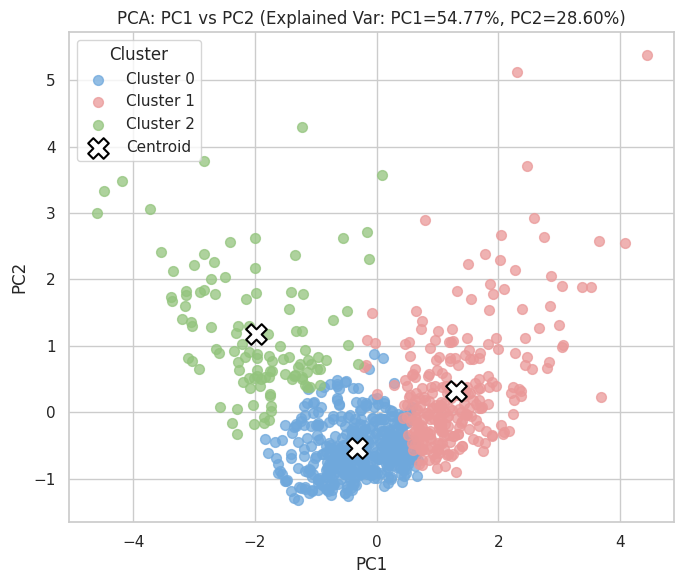

In [ ]:
# ==== PCA 2D untuk visualisasi cluster ====
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import cycle

sns.set(style="whitegrid")

# Ambil fitur RFM
features = ['recency', 'frequency', 'monetary']
X = rfm[features].values

# Scaling (wajib)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA ke 2 komponen
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Tambah hasil PCA ke dataframe
rfm['PC1'] = X_pca[:, 0]
rfm['PC2'] = X_pca[:, 1]

# --- Warna lembut biar konsisten ---
soft_colors = ['#6FA8DC', '#EA9999', '#93C47D']  # biru, merah, hijau
cluster_order = sorted(rfm['cluster'].unique())
color_cycle = cycle(soft_colors)
palette_map = {c: next(color_cycle) for c in cluster_order}
ordered_colors = [palette_map[c] for c in cluster_order]

# --- Plot PCA ---
fig, ax = plt.subplots(figsize=(7, 6))

for c in cluster_order:
    mask = rfm['cluster'] == c
    ax.scatter(
        rfm.loc[mask, 'PC1'], rfm.loc[mask, 'PC2'],
        alpha=0.75, s=50, label=f'Cluster {c}',
        color=palette_map[c]
    )

# Tambahkan centroid
centroids = rfm.groupby('cluster')[['PC1', 'PC2']].mean()
ax.scatter(
    centroids['PC1'], centroids['PC2'],
    s=220, marker='X', edgecolor='black',
    linewidth=1.5, facecolor='white', label='Centroid'
)

# Variance explained
var1, var2 = pca.explained_variance_ratio_
ax.set_title(f'PCA: PC1 vs PC2 (Explained Var: PC1={var1:.2%}, PC2={var2:.2%})')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(title='Cluster')

plt.tight_layout()
plt.show()